### $\textbf{QuantCo Causal Inference Project}$
##### Wian Stipp

### Describing The Problem:

We are using a study to compare the quality of services provided by two physician groups for asthma patients in California. Let $Y_i(z)$ be the score (1 = satisfactory, 0 = non-satisfactory) given by patient $i$ for the treatment recieved by physician  group $z \in \{1,2\}$ 
Besides the treatment variable and the outcome variable we have a list of covariates: 'age', 'sex', 'education', 'insurance', 'drug coverage', 'severity', 'comorbidity', 'physical comorbidity', 'mental comorbidity'.

Comorbidity is defined as: the presence of one or more additional conditions co-occurring with a primary condition; in the countable sense of the term, a comorbidity is each additional condition. The additional condition may also be a behavioral or mental disorder.

We assume the treatment assignment is ignorable conditional on all the pretreatment variables

#### The Objective

We are using a study to compare the quality of services provided by two physician groups for asthma patients in California. Our objective is to find the average treatment (causal) effect of each physician compared to the other. That is if $p_z$ is the fraction of patients that would be satisfied with the service of $z$ if all patients were treated by the same, then we want to find $p_1 - p_2$.

here is, however, a more interesting insight we can find; We can find which types of people would be more satisified with each of the physician groups. This is a problem known as heterogeneous treatment effect (HTE) estimation. In this project, we will explore how a causal tree-based learning method can find heterogeneity in the treatment effects.


#### The Data

The data is sourced from http://www.biostat.jhsph.edu/~cfrangak/biostat_causal/asthma.txt. We are going to split the data into a training, validation and testing subset such that we can test the model on out-of-sample data.

#### The Model

We are primarily using the work published 2019: "Learning Triggers for Heterogeneous Treatment Effects" by Christopher Tran and Elena Zheleva.

# The Project

## Data Visualisation and Preparation

We first start off by importing the relevant data and packages we will be using.

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
dataframe = pd.read_csv('data/asthma.txt', delimiter=' ', index_col=None)

Let's explore the data a little bit

In [185]:
dataframe.head()

,pg,i.age,i.sex,i.educ,i.insu,i.drug,i.seve,com.t,pcs.sd,mcs.sd,i.aqoc
0,1,36,0,5,1,1,2,4,49.97533,49.57280,1
1,1,37,1,6,2,1,3,3,40.93979,56.11393,1
2,1,43,1,5,1,1,4,3,50.32495,57.11961,1
3,1,39,1,6,1,1,4,1,49.34402,49.65159,1
4,1,46,1,1,2,1,4,0,37.37425,52.95411,0


In [186]:
dataframe.describe()

,pg,i.age,i.sex,i.educ,i.insu,i.drug,i.seve,com.t,pcs.sd,mcs.sd,i.aqoc
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,1.623188,39.960145,0.699275,4.818841,1.478261,0.981884,2.615942,2.173913,45.649891,48.588685,0.673913
std,0.485467,8.790193,0.459406,0.970365,0.908284,0.133613,0.924986,1.454338,10.227349,9.785507,0.469631
min,1.000000,19.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,9.176023,13.458770,0.000000
25%,1.000000,34.000000,0.000000,4.000000,1.000000,1.000000,2.000000,1.000000,39.905275,43.790342,0.000000
50%,2.000000,40.000000,1.000000,5.000000,1.000000,1.000000,3.000000,2.000000,47.586820,50.667165,1.000000
75%,2.000000,47.000000,1.000000,6.000000,2.000000,1.000000,3.000000,3.000000,53.696978,56.036845,1.000000
max,2.000000,55.000000,1.000000,6.000000,5.000000,1.000000,4.000000,9.000000,65.338440,65.496670,1.000000


In [187]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 11 columns):
pg        276 non-null int64
i.age     276 non-null int64
i.sex     276 non-null int64
i.educ    276 non-null int64
i.insu    276 non-null int64
i.drug    276 non-null int64
i.seve    276 non-null int64
com.t     276 non-null int64
pcs.sd    276 non-null float64
mcs.sd    276 non-null float64
i.aqoc    276 non-null int64
dtypes: float64(2), int64(9)
memory usage: 23.8 KB


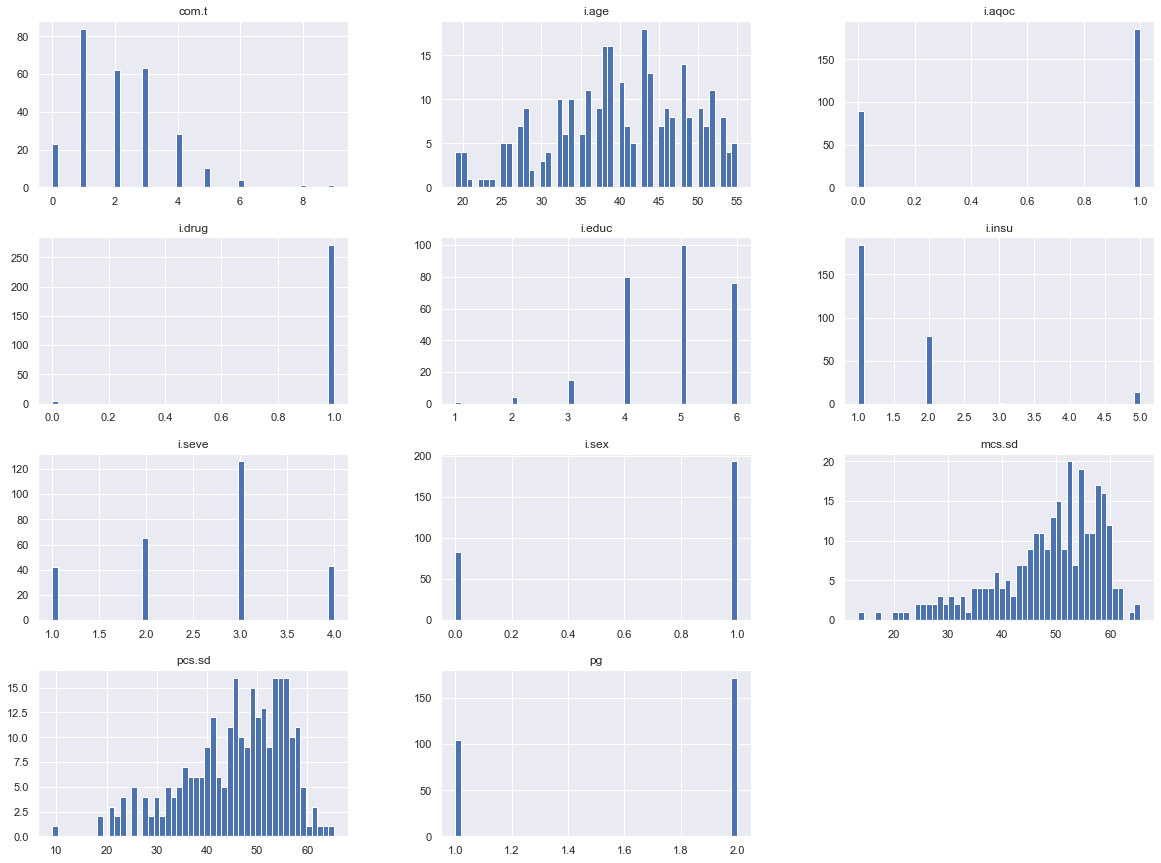

In [188]:
import matplotlib.pyplot as plt
dataframe.hist(bins=50, figsize=(20,15))
plt.show()

It seems like the covariate i.drug is heavily imbalanced and so won't add much value to our model (apart from making us more likely to overfit), and therefore we can discard it.

Besides that, the rest of the data looks well distributed with a few covariates taking a log-normal looking shape.

In [189]:
dataframe = dataframe.drop(["i.drug"], axis=1)

In [190]:
dataframe.head()

,pg,i.age,i.sex,i.educ,i.insu,i.seve,com.t,pcs.sd,mcs.sd,i.aqoc
0,1,36,0,5,1,2,4,49.97533,49.57280,1
1,1,37,1,6,2,3,3,40.93979,56.11393,1
2,1,43,1,5,1,4,3,50.32495,57.11961,1
3,1,39,1,6,1,4,1,49.34402,49.65159,1
4,1,46,1,1,2,4,0,37.37425,52.95411,0


One thing to notice is that the "pg" variable is labeled with {1,2}. Let's relabel this to avoid confusion with convention.

In [191]:
dataframe[dataframe["pg"] == 2].loc[:,"pg"] = 1
dataframe[dataframe["pg"] == 1].loc[:,"pg"] = 0

C:\Users\stipp\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [192]:
dataframe.head()

,pg,i.age,i.sex,i.educ,i.insu,i.seve,com.t,pcs.sd,mcs.sd,i.aqoc
0,1,36,0,5,1,2,4,49.97533,49.57280,1
1,1,37,1,6,2,3,3,40.93979,56.11393,1
2,1,43,1,5,1,4,3,50.32495,57.11961,1
3,1,39,1,6,1,4,1,49.34402,49.65159,1
4,1,46,1,1,2,4,0,37.37425,52.95411,0


Now at this stage we should set some data aside for testing and validation. If we don't do so we are likely to add bias into the model and to overfit (data snooping bias). Since the dataset is relatively small, we use stratified sampling to ensure that the data is as representative of the population as possible with respect to the treatment variable.

In [193]:
from sklearn.model_selection import StratifiedShuffleSplit

In [194]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=12)
for train_index, test_index in split.split(dataframe, dataframe["pg"]):
    strat_train_set = dataframe.loc[train_index]
    strat_test_set = dataframe.loc[test_index]

We can now explore the correlations between variables to check for any multicollinearity problems that could arise (that would also lead to a high variance model).

In [195]:
strat_train_set

,pg,i.age,i.sex,i.educ,i.insu,i.seve,com.t,pcs.sd,mcs.sd,i.aqoc
112,2,32,1,6,2,2,1,55.07315,24.43128,0
53,1,41,1,4,1,4,4,33.41873,33.41732,1
93,1,20,1,4,1,2,2,44.92749,35.24172,1
84,1,40,0,6,1,1,1,37.23123,56.46801,1
56,1,44,1,6,1,3,2,50.78630,59.10188,1
...,...,...,...,...,...,...,...,...,...,...
170,2,39,1,5,1,3,1,50.42865,37.29286,0
14,1,51,0,6,1,3,4,41.06879,46.04102,1
77,1,48,0,2,1,3,5,33.27224,39.15091,1
224,2,34,0,6,1,1,2,56.34995,57.86367,1


In [196]:
correlations = strat_train_set.corr()
correlations["i.aqoc"].sort_values(ascending=False)

i.aqoc    1.000000
com.t     0.192830
i.age     0.168820
i.sex     0.052145
i.educ    0.021557
pcs.sd   -0.077443
mcs.sd   -0.098633
i.insu   -0.123758
i.seve   -0.144693
pg       -0.154187
Name: i.aqoc, dtype: float64

From the correlations we observe that the treatment (physician group) is negatively correlated with the outcome of interest. That is, physician group (pg) 1 is correlated with a lower satisfaction score.

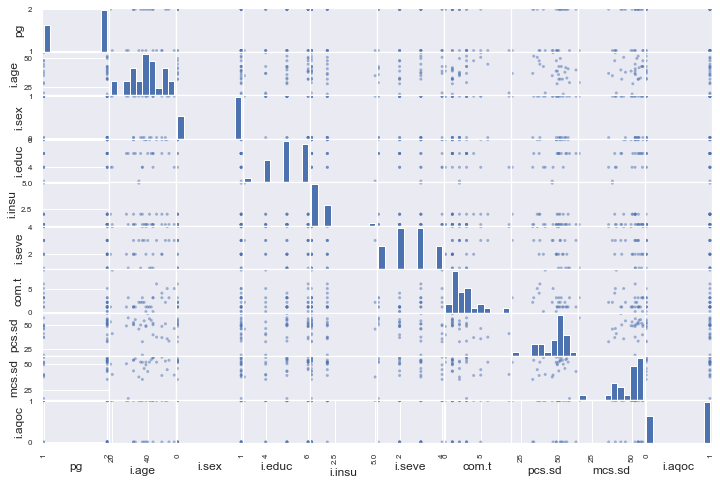

In [197]:
from pandas.plotting import scatter_matrix

scatter_matrix(strat_test_set, figsize=(12, 8))

plt.show()

From the visualisation we can see some variables seem to be correlated. Let's have a closer look at com.t against i.age (comorbidity against age).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


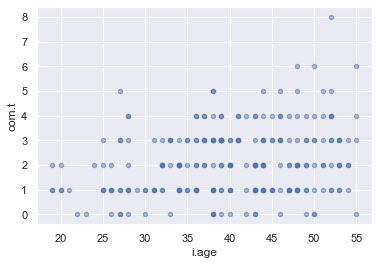

In [198]:
strat_train_set.plot(kind="scatter", y="com.t", x="i.age",
 alpha=0.5)

There seems to be a positive correlation between age and comorbidity. Let's fit an OLS model to explore this further. 

In [199]:
import statsmodels.api as sm

In [200]:
results = sm.OLS(strat_train_set["com.t"], sm.add_constant(strat_train_set["i.age"])).fit(cov_type="HC1")

C:\Users\stipp\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [201]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  com.t   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     17.77
Date:                Thu, 21 Nov 2019   Prob (F-statistic):           3.51e-05
Time:                        04:28:27   Log-Likelihood:                -423.44
No. Observations:                 248   AIC:                             850.9
Df Residuals:                     246   BIC:                             857.9
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5092      0.374      1.363      0.1

Let's run a t-test with

$$ H_0 : \beta = 0 \ \ \ \ vs. \ \ H_1:  \beta \ \neq 0 $$

where our model is

$$ com_i = \alpha + \beta \times age_i $$

for $i=1,2,...,n$ where $n$ is the number of patients in the training set.

In [202]:
r = np.zeros_like(results.params)
r[1] += 1
T_test = results.t_test(r)
print(T_test)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0409      0.010      4.215      0.000       0.022       0.060


From this we can see that the result, with a p-value of 0.000, is significant at the 5% significance level. That is, we can reject the null hypothesis and conclude that there is sufficient evidence to suggest that there is a correlation between age and comorbidity. We can plot the result below.

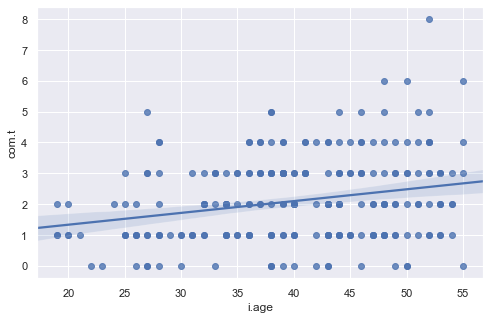

In [203]:
import seaborn as sns; sns.set(color_codes=True)

X_plot = np.linspace(0,30,60)
plt.figure(figsize=(8, 5))

ax= sns.regplot(x=strat_train_set["i.age"], y=strat_train_set["com.t"], color="b", robust=True)
plt.show()

### A Benchmark Model

Before we build the tree-based causal model, we can build a simple OLS model. We will use matching to control for the confounders and reduce selection bias. What we observe, for each i, is

$$ E[Y_{1i} | T_i=1] - E[Y_{0i} | T_i=0] $$

However we want find the average treatment effect

$$ E[Y_{1i}-Y_{0i} | T_i=1] $$

But there exists selection bias - which is bias that is systematically introduced, because

$$ 
\begin{align}
E[Y_{1i} | T_i=1] - E[Y_{0i} | T_i=0] &= E[Y_{1i} | T_i=1] - E[Y_{0i} | T_i=1] + E[Y_{0i} | T_i=1] - E[Y_{0i} | T_i=0] \\
&= E[Y_{1i}-Y_{0i} | T_i=1] + E[Y_{0i} | T_i=1] - E[Y_{0i} | T_i=0] \\
observed \ effect &= treatment \ effect + selection \ bias
\end{align}
$$

We can use matching to control for the confounders to reduce the selection bias as close as possible to zero such that we can observe the causal effect of each physician group on the satisfaction of the patients. We need to make a story to select which covariates we want to choose. We also need to check that the controls we introduce are "good controls", or at least "neutral controls". That means that two properties should hold: (1) aer determined prior to the process that leads from the regressor of
interest (the treatment) to outcomes, and (2) are immutable characteristics of the units of observation.


We need to control for the fact that patients across the treatments are systematically different in some way.

We choose mental comorbidity to control for the general positivity/negativity of the patient. The positivity of a patient is likely to influence the satisfaction rating the patient gives the physician and so this is an example of a neutral control. This is possibly good for precision as it could reduce the variance of the residual.

Another control we choose is "severity". If we consider health as a confounder, health may influence the treatment because a patient may choose to go to a certain doctor based on repuation. Then health is also influencing Y because if a patient is healthier, he/she is more likely to be satisfied with the physician. This is an example of a good control with which we are blocking the "back-door" from T to Y by introducing a proxy "severity" as a proxy to health.

Thus our model is

$$ \text{satisfaction}_i = \alpha + \beta \times \text{physician group}_i + \zeta_1 \times \text{mental comorbidity}_i + \zeta_2 \times \text{severity}_i + \varepsilon_i $$

Let's build this model in statsmodels and run the regression.

### Appendix

#### Heterogeneous treatment effect estimation

We are trying to estimate the conditional average treatment effect (CATE) using a set of features. We define the CATE as:

$$\tau(x) := E[Y_{1i}-Y_{i0} | X_i = \textbf{x}]$$

We need to find an estimate $\hat{\tau}(x)$ for the CATE. Clearly we need to partition the feature space. Our dataset, S, needs to have the form:

$$ S = \{ { \textbf{X}_i, Y_i, T_i): \textbf{X}_i \in \mathcal{X}} \} $$

Where $Y_i$ is the outcome, $T_i$ is the binary variable for the treatment, and $\textbf{X}_i$ the feature vector containing the other covariates.

A partitioning of the feature space into L partitions is defined as

$$ \mathcal{X} = \mathcal{X}_1 \cup \mathcal{X}_2 \cup ... \cup \mathcal{X}_L $$

The subsets should be mutually exclusive and collectively exhaustive of $\mathcal{X}$. Then

$$ S_l = \{ { \textbf{X}_i, Y_i, T_i): \textbf{X}_i \in \mathcal{X}_l} \} $$

Now it follows that the conditional mean for the outcome and control in a particular partition $\mathcal{X}_l$ is defined as:

$$ \hat{\mu}_t(S_l) = \frac{1}{N_{l_t}} \sum_{T_i=t, i \in S_l}^{} Y_i $$

where  $t \in {0,1} : \hat{\mu}_1, \hat{\mu}_2 $ are the conditional means. Capital N is indexed by the partition's treatment and control group. With this information we can find the average causal effect (ACE) for a given partitiond defined by:

$$ \hat{\tau}(S_l) = \hat{\mu}_1(S_l) - \hat{\mu}_0(S_l) $$

We can use trees for heterogeneous treatment effect estimation by representing each partition by a tree. Trees are built greedily to maximise F, a partition measure that measures the average causal effect for the given partition. For example, if we want to split a particular node, the algorith will split in such a way as to maximise "F" on its children.

It can be beneficial to add a penalty to the splitting criteria. This is called the "honest" approach (CT-H).